# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [8]:
from random import random, seed
from itertools import accumulate
import numpy as np
from icecream import ic
from matplotlib import pyplot as plt

# Summary
- [Reproducible Inizialition (UNIVERSE, SETS and DENSITY)](#reproducible-initialization)
- [Some helper functions (valid and cost)](#helper-functions)
- [RMHC (Simple and Multiple tweaking)](#RHMC-Random-Mutation-Hill-Climbing)
- [Tabu Search](#Tabu-Search)
    - [Starting from a greedy solution](#starting-from-a-greedy-solution)
    - [Generation of neighbors](#generation-of-neighbors)
    - [The algorithm](#algorithm)
    - [Conclusions](#plots-and-conclusions)

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [9]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

Generate a boolean 2D array of shape (`NUM_SETS`, `UNIVERSE_SIZE`). Each element will be `True` if the random floating-point number is less than `DENSITY`, `False` otherwise. Guarantee that each element of the universe (each column in `SETS` collection) is included in at least one set (each column in the `SETS` array has at least one `True` value). At the end, calculate the cost for each set in `SETS`, where the cost increases non-linearly with the number of elements in the set.

In [10]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [11]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [12]:
# A dumb solution of "all" sets
dumb_solution = np.full(NUM_SETS, True)
valid(dumb_solution), cost(dumb_solution)

(np.True_, np.float64(4278063.272256091))

## RMHC (Random Mutation Hill Climbing)

Hill climbing algorithm has the tendency to become stuck in suboptimal regions (local optima) since it only accepts improvements. It works fine in convex search spaces. Two functions are implemented.
- `single_mutation`: only one element of the solution array is randomly selected and flipped. Small and localized change in the solution (*exploitation*);
- `multiple_mutation`: several elements of the solution array are mutated simultaneously. More aggressive changes (*exploration*);
- `multiple_mutation_strength`: a different number of elements in the solution array are mutated, depending on the value of `strength` parameter. It is possible to adjust it during the process of optimization (high strength at the start for more exploration, lower strength as the search narrows in on good solutions for fine-tuning). We are using this function in the next example.

In [13]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    new_solution = solution.copy()
    random_set = rng.integers(0, NUM_SETS)
    new_solution[random_set] = not new_solution[random_set]
    return new_solution

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < 0.01  # Only 1% of the elements in the solution array have a chance of being mutated
    new_solution = np.logical_xor(solution, mask)
    return new_solution

def multiple_mutation_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    # Ensures that the function always mutates at least one bit
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

def fitness(solution: np.ndarray) -> tuple[bool, float]:
    return (valid(solution), -cost(solution))

Start with a random solution. Greedy solution can lead to a local optima (**basins of attraction**). It is possible not to identify a global optima.

ic| solution_fitness: (np.True_, np.float64(-4278063.272256091))
ic| fitness(solution): (np.True_, np.float64(-1786150.104137423))


Text(0, 0.5, 'Fitness')

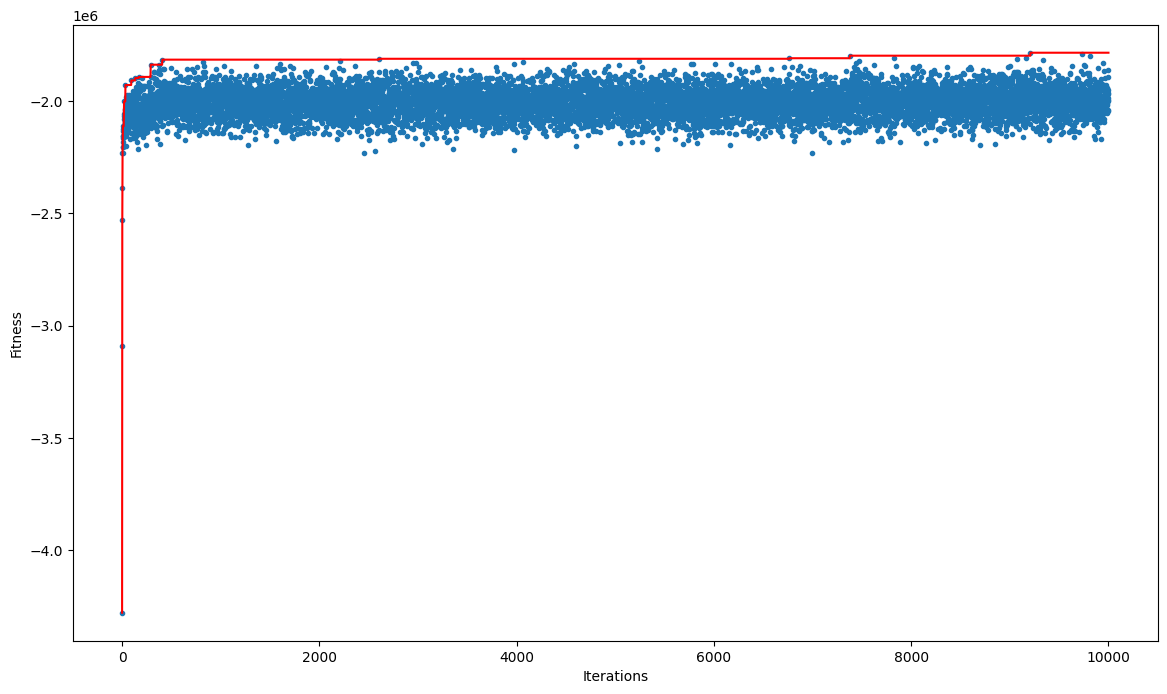

In [14]:
strength = 0.5  # High strength at the beginning of the optimization process

solution = rng.random(NUM_SETS) < 1   # A random solution of all True
solution_fitness = fitness(solution)
ic(solution_fitness)
history = [float(solution_fitness[1])]


for steps in range(10000):
    if steps % 1000:
        strength /= 2   # decrease strength (mutation rate)
    new_solution = multiple_mutation_strength(solution)
    history.append(float(fitness(new_solution)[1]))
    if fitness(new_solution) > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)

ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(range(len(history)), list(accumulate(history, max)), color = "red")
_ = plt.scatter(range(len(history)), history, marker=".")
plt.xlabel("Iterations")
plt.ylabel("Fitness")

## Tabu Search

In [15]:
# Tabu parameters
ITERATION_NO_IMPROVEMENTS = 100     # threshold for considering stagnation (no fitness improvements)
MAX_ITERATIONS = 1000
TABU_SIZE = 10

### Starting from a greedy solution
Using a *greedy approach* iteratively selects the subset that covers the largest number of uncovered elements, continuing until all elements of the universe are covered. At each step, choose the locally optimal solution (the subset with the greatest immediate coverage), without backtracking, in order to build a solution that is efficient but not necessarily globally optimal.

In [16]:
def greedy_initial_solution():
    solution = []   # [np.int64(0), np.int64(1), np.int64(2), np.int64(4)]
    not_covered_elements = np.ones(UNIVERSE_SIZE, dtype = bool)     # no element is covered
    
    while np.any(not_covered_elements): # until all elements are covered
        coverage = np.dot(SETS, not_covered_elements)
        selected_set = np.argmax(coverage)
        solution.append(selected_set)
        not_covered_elements = np.logical_and(not_covered_elements, ~SETS[selected_set])
    
    boolean_solution = [True if set_index in solution else False for set_index in range(NUM_SETS)]  # [True, True, True, False, True]

    return boolean_solution

### Generation of neighbors

In [17]:

def get_neighbors(solution: np.ndarray) -> list[np.ndarray]:
    neighborhood = []
    for set_index in range(NUM_SETS):
        new_solution = solution.copy()
        new_solution[set_index] = not new_solution[set_index]
        if(valid(new_solution)):
            neighborhood.append(new_solution)
    return neighborhood

### Algorithm

In [18]:
current_solution = greedy_initial_solution()
fitness_solution = fitness(current_solution)
ic(fitness_solution)    # at the beginning

no_improvements = 0     # no improvements count
history = [float(fitness_solution[1])]
tabu_list = []

for iteration in range(MAX_ITERATIONS):
    neighbors = get_neighbors(current_solution)
    history.append(float(fitness_solution[1]))
    improved = False

    for neighbor in neighbors:
        if(fitness(neighbor) > fitness_solution and not any(np.array_equal(neighbor, tabu) for tabu in tabu_list)):
            improved = True     # there is an improvement
            no_improvements = 0 # reset counter
            current_solution = neighbor
            fitness_solution = fitness(neighbor)
            tabu_list.append(current_solution)
            if len(tabu_list) >= TABU_SIZE:
                tabu_list.pop(0)
            break

    if not improved:
        no_improvements += 1
    
    if no_improvements >= ITERATION_NO_IMPROVEMENTS:
        break

ic(fitness_solution)    # at the end

ic| fitness_solution: (np.True_, np.float64(-162401.87967678832))
ic| fitness_solution: (np.True_, np.float64(-128112.7869902012))


(np.True_, np.float64(-128112.7869902012))

### Plots and conclusions

Text(0, 0.5, 'Fitness')

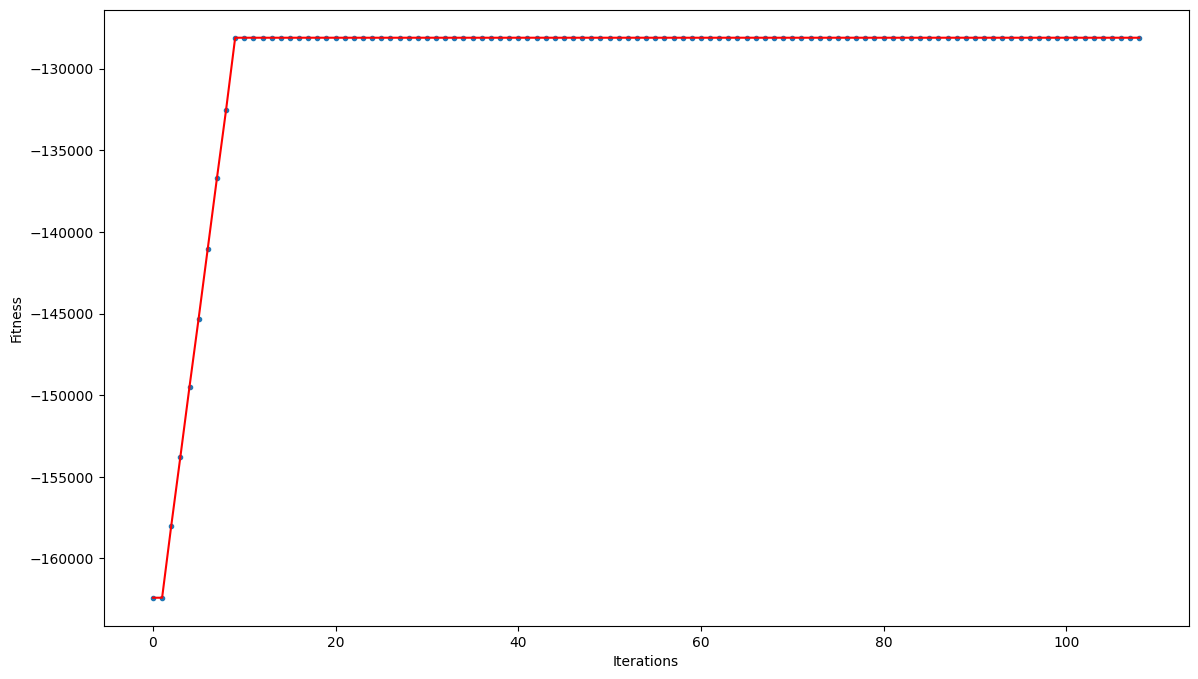

In [19]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(history)), list(accumulate(history, max)), color = "red")
_ = plt.scatter(range(len(history)), history, marker=".")
plt.xlabel("Iterations")
plt.ylabel("Fitness")

In [20]:
print(f"Final fitness tabu search: {fitness(current_solution)}")
selected_sets = [i for i in range(NUM_SETS) if current_solution[i] == True]
print(f"Selected sets: {selected_sets}")

Final fitness tabu search: (np.True_, np.float64(-128112.7869902012))
Selected sets: [1, 2, 4, 6, 8, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 34, 35, 36, 40, 42, 46]
